# Importing necessary tools

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sn
from gensim.models import KeyedVectors
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense, Input
from keras.layers import TimeDistributed
from keras.layers import LSTM, GRU, Bidirectional, SimpleRNN, Dropout

from keras.models import Model
from keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Data Pre-Processing

In [2]:
with open("clean_az_brown2.txt", 'r', encoding='utf-8') as f:
    s2 = f.read().splitlines()
    
s3 = [re.sub('\n', '', sentence) for sentence in s2]    

tagged_sentences = [sentence.split(" ") for sentence in s3]

corpus = [[tuple(word.split("/")) for word in sentence] for sentence in tagged_sentences]

print(corpus[0])

[('Həkan-həkan', 'Isim'), ('içində', 'Zərf'), (',', ','), ('qoz', 'Isim'), ('girdəkan', 'Isim'), ('içində', 'Zərf'), (',', ','), ('dəvə', 'Isim'), ('dəlləklik', 'Isim'), ('elər', 'Fel'), (',', ','), ('köhnə', 'Sifət'), ('hamam', 'Isim'), ('içində', 'Zərf'), ('.', 'Durğu_işarəsi')]


# Word & Tag Seperation

In [3]:
X = [] # store input sequence
Y = [] # store output sequence

for sentence in corpus:
    X_sentence = []
    Y_sentence = []
    for entity in sentence:         
        X_sentence.append(entity[0])  # entity[0] contains the word
        Y_sentence.append(entity[1])  # entity[1] contains corresponding tag
        
    X.append(X_sentence)
    Y.append(Y_sentence)  

# Encoding

In [4]:
# encode X
word_tokenizer = Tokenizer(oov_token='-OOV-', lower=False) # instantiate tokeniser
word_tokenizer.fit_on_texts(X)                    # fit tokeniser on data
word2index = word_tokenizer.word_index
X_encoded = word_tokenizer.texts_to_sequences(X)  # use the tokeniser to encode input sequence

# encode Y
tag_tokenizer = Tokenizer(lower=False)
tag_tokenizer.fit_on_texts(Y)
tag2index = tag_tokenizer.word_index
Y_encoded = tag_tokenizer.texts_to_sequences(Y)


In [5]:
# words, tags = set([]), set([])

# for s in sentences:
#     for w in s:
#         words.add(w)
        
# for ts in sentence_tags:
#     for t in ts:
#         tags.add(t)
        
# word2index = {w: i + 1 for i, w in enumerate(list(words))}
# tag2index = {t: i + 1 for i, t in enumerate(list(tags))}

In [6]:
# sentences_encoded, sentence_tags_encoded = [], []

# for s in sentences:
#     s_int = []
#     for w in s:
#         try:
#             s_int.append(word2index[w])
#         except KeyError:
#             pass
 
#     sentences_encoded.append(s_int)
    
# for s in sentence_tags:
#     sentence_tags_encoded.append([tag2index[t] for t in s])      

# print("** Raw data point **", "\n", "-"*100, "\n")
# print('X: ', sentences[0], '\n')
# print('Y: ', sentence_tags[0], '\n')
# print()
# print("** Encoded data point **", "\n", "-"*100, "\n")
# print('X: ', sentences_encoded[0], '\n')
# print('Y: ', sentence_tags_encoded[0], '\n')

Total number of tagged sentences: 1806
Vocabulary size: 7073
Total number of tags: 15
0 sentences have disparate input-output lengths.
Length of longest sentence: 88


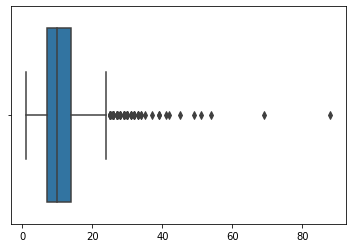

In [7]:
print("Total number of tagged sentences: {}".format(len(corpus)))
print("Vocabulary size: {}".format(len(word2index)))
print("Total number of tags: {}".format(len(tag2index)))


# make sure that each sequence of input and output is same length

different_length = [1 if len(input) != len(output) else 0 for input, output in zip(X_encoded, Y_encoded)]
print("{} sentences have disparate input-output lengths.".format(sum(different_length)))

# check length of longest sentence
lengths = [len(seq) for seq in X_encoded]
print("Length of longest sentence: {}".format(max(lengths)))

sn.boxplot(lengths)
plt.show()

# Pad sequence

In [8]:
# Pad each sequence to MAX_SEQ_LENGTH using KERAS' pad_sequences() function. 

# Truncation and padding can either be 'pre' or 'post'. 
# We will use padding with 'post'

MAX_SEQ_LENGTH = 88  # sequences lesser than 88 will be added zeros

X_padded = pad_sequences(X_encoded, maxlen=MAX_SEQ_LENGTH, padding="post")
Y_padded = pad_sequences(Y_encoded, maxlen=MAX_SEQ_LENGTH, padding="post")

In [9]:
# print the first sequence
print(X_padded[0], "\n"*3)
print(Y_padded[0])

[2154  217    3  768 1200  217    3 2155 2156 2157    3  555 2158  217
    2    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0] 



[1 7 6 1 1 7 6 1 1 2 6 5 1 7 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


#### RNN will learn the zero to zero mapping while training. So we don't need to worry about the padded zeroes. Please note that zero is not reserved for any word or tag, it's only reserved for padding.

In [10]:
# assign padded sequences to X and Y
X, Y = X_padded, Y_padded

# WORD EMBEDDING

Currently, each word and each tag is encoded as an integer.

We'll use a more sophisticated technique to represent the input words (X) using what's known as word embeddings.

However, to represent each tag in Y, we'll simply use one-hot encoding scheme since there are only 13 tags in the dataset and the models won't have any problems in learning its own representation of these tags.

To use word embeddings, you can go for either of the following models:

* word2vec model: https://code.google.com/archive/p/word2vec/
* GloVe model : https://nlp.stanford.edu/projects/glove/
* fastText : https://fasttext.cc/docs/en/crawl-vectors.html

We're using the fastText model because they have pre-trained model for Azerbaijani lanuage.

Dimensions of a word embedding is: (VOCABULARY_SIZE, EMBEDDING_DIMENSION)

In [11]:
import fasttext

path = 'D:/PostgresData/cc.az.300.bin'
ft = fasttext.load_model(path)

In [12]:
# assign word vectors from word2vec model

EMBEDDING_SIZE  = 300  # each word in word2vec model is represented using a 300 dimensional vector
VOCABULARY_SIZE = len(word2index) + 1

# create an empty embedding matix
embedding_weights = np.zeros((VOCABULARY_SIZE, EMBEDDING_SIZE))

# copy vectors from fasttext model to the words present in corpus
for w, i in word2index.items():
    try:
        embedding_weights[i, :] = ft[w]
    except KeyError:
        pass

In [13]:
# check embedding dimension
print("Embeddings shape: {}".format(embedding_weights.shape))

Embeddings shape: (7074, 300)


In [14]:
# use Keras' to_categorical function to one-hot encode Y
Y = to_categorical(Y)

In [15]:
# print Y of the first output sequqnce
print(Y.shape)

(1806, 88, 16)


In [16]:
# split entire data into training and testing sets
TEST_SIZE = 0.2
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=TEST_SIZE, random_state=8)

# split training data into training and validation sets
VALID_SIZE = 0.25
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=VALID_SIZE, random_state=8)

In [17]:
# print number of samples in each set
print("TRAINING DATA")
print('Shape of input sequences: {}'.format(X_train.shape))
print('Shape of output sequences: {}'.format(Y_train.shape))
print("-"*50)
print("VALIDATION DATA")
print('Shape of input sequences: {}'.format(X_validation.shape))
print('Shape of output sequences: {}'.format(Y_validation.shape))
print("-"*50)
print("TESTING DATA")
print('Shape of input sequences: {}'.format(X_test.shape))
print('Shape of output sequences: {}'.format(Y_test.shape))

TRAINING DATA
Shape of input sequences: (1083, 88)
Shape of output sequences: (1083, 88, 16)
--------------------------------------------------
VALIDATION DATA
Shape of input sequences: (361, 88)
Shape of output sequences: (361, 88, 16)
--------------------------------------------------
TESTING DATA
Shape of input sequences: (362, 88)
Shape of output sequences: (362, 88, 16)


#### Before using RNN, we must make sure the dimensions of the data are what an RNN expects. In general, an RNN expects the following shape

* Shape of X: (#samples, #timesteps, #features)

* Shape of Y: (#samples, #timesteps, #features)

Now, there can be various variations in the shape that you use to feed an RNN depending on the type of architecture. Since the problem we're working on has a many-to-many architecture, the input and the output both include number of timesteps which is nothing but the sequence length. But notice that the tensor X doesn't have the third dimension, that is, number of features. That's because we're going to use word embeddings before feeding in the data to an RNN, and hence there is no need to explicitly mention the third dimension. That's because when you use the Embedding() layer in Keras, you the training data will automatically be converted to (#samples, #timesteps, #features) where #features will be the embedding dimension (and note that the Embedding layer is always the very first layer of an RNN). While using the embedding layer we only need to reshape the data to (#samples, #timesteps) which is what we have done. However, note that you'll need to shape it to (#samples, #timesteps, #features) in case you don't use the Embedding() layer in Keras.

In [42]:
NUM_CLASSES = Y.shape[2]
BILSTM_DROPOUT = 0.7
BILSTM_HIDDEN_LAYER_SIZE = 64
BATCH_SIZE = 5
EPOCH_SIZE = 5

# F1, PRECISION, RECALL SCORES

In [43]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# def ignore_class_accuracy(to_ignore=0):
#     def ignore_accuracy(y_true, y_pred):
#         y_true_class = K.argmax(y_true, axis=-1)
#         y_pred_class = K.argmax(y_pred, axis=-1)
 
#         ignore_mask = K.cast(K.not_equal(y_pred_class, to_ignore), 'int32')
#         matches = K.cast(K.equal(y_true_class, y_pred_class), 'int32') * ignore_mask
#         accuracy = K.sum(matches) / K.maximum(K.sum(ignore_mask), 1)
#         return accuracy
#     return ignore_accuracy
# , ignore_class_accuracy(0)

# 4. Bidirectional LSTM

In [44]:
# create architecture

bidirect_model = Sequential()
bidirect_model.add(Embedding(input_dim     = VOCABULARY_SIZE,
                             output_dim    = EMBEDDING_SIZE,
                             input_length  = MAX_SEQ_LENGTH,
                             weights       = [embedding_weights],
                             trainable     = True
))
bidirect_model.add(Bidirectional(LSTM(64, return_sequences=True)))
bidirect_model.add(Dropout(0.7))
bidirect_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

bidirect_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc', f1_m, precision_m, recall_m])

# check summary of model
bidirect_model.summary()

bidirect_training = bidirect_model.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=EPOCH_SIZE, validation_data=(X_validation, Y_validation))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 88, 300)           2122200   
                                                                 
 bidirectional_1 (Bidirectio  (None, 88, 128)          186880    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 88, 128)           0         
                                                                 
 time_distributed_1 (TimeDis  (None, 88, 16)           2064      
 tributed)                                                       
                                                                 
Total params: 2,311,144
Trainable params: 2,311,144
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
217/217 [=========================

# Evaluation

In [45]:
blstm_64_loss, blstm_64_accuracy, blstm_64_f1_score, blstm_64_precision, blstm_64_recall = bidirect_model.evaluate(X_test, Y_test, verbose = 1)

12/12 [==============================] - 0s 24ms/step - loss: 0.0582 - acc: 0.9832 - f1_m: 0.9828 - precision_m: 0.9848 - recall_m: 0.9808


In [57]:
test_samples = [
    "Daşı daşı .".split(),
    "Mən səhərlər dənizə doğru qaçıram .".split()
]
print(test_samples)

test_samples_X = []

for s in test_samples:
    s_int = []
    for w in s:
        try:
            s_int.append(word2index[w])
        except KeyError:
            s_int.append(word2index['-OOV-'])
    test_samples_X.append(s_int)
    
test_samples_X = pad_sequences(test_samples_X, maxlen=MAX_SEQ_LENGTH, padding='post')
print(test_samples_X)

[['Daşı', 'daşı', '.'], ['Mən', 'səhərlər', 'dənizə', 'doğru', 'qaçıram', '.']]
[[7063  803    2    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]
 [  20    1 1637  369    1    2    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]]


In [58]:
predictions = bidirect_model.predict(test_samples_X)
print(predictions, predictions.shape)

[[[3.9015308e-03 9.6371078e-01 2.3617987e-02 ... 5.9370991e-06
   4.8222748e-05 2.3222769e-05]
  [7.9643872e-04 6.6215202e-02 9.2670941e-01 ... 5.2735750e-06
   5.1667659e-05 1.5931744e-05]
  [3.0815729e-03 1.4121223e-05 1.4360866e-04 ... 2.6191594e-05
   1.0649067e-05 1.5480004e-05]
  ...
  [9.9999261e-01 5.1313503e-07 1.2103123e-07 ... 1.2062948e-06
   6.1814086e-07 1.4401484e-06]
  [9.9996674e-01 7.3406306e-07 2.3617459e-07 ... 8.6759255e-06
   3.1104385e-06 7.5706757e-06]
  [9.9984646e-01 1.0935568e-06 4.6852333e-07 ... 5.5329405e-05
   1.4177645e-05 3.6395741e-05]]

 [[8.2306542e-06 1.4812345e-04 1.3373687e-04 ... 1.1759745e-06
   1.6169921e-05 6.8520858e-06]
  [3.4128043e-03 8.3966792e-01 2.4667645e-02 ... 1.6957552e-04
   9.5505425e-04 5.3018989e-04]
  [2.0721214e-05 9.9796200e-01 6.6719123e-04 ... 4.1874014e-07
   3.1412703e-06 9.7783288e-07]
  ...
  [9.9999225e-01 5.1598352e-07 1.2174476e-07 ... 1.2424539e-06
   6.3496174e-07 1.4811109e-06]
  [9.9996579e-01 7.3807416e-07 2.375

In [59]:
def logits_to_tokens(sequences, index):
    token_sequences = []
    for categorical_sequence in sequences:
        token_sequence = []
        for categorical in categorical_sequence:
            try:
                token_sequence.append(index[np.argmax(categorical)])
            except KeyError:
                pass
        token_sequences.append(token_sequence)
 
    return token_sequences

In [60]:
result = logits_to_tokens(predictions, {i: t for t, i in tag2index.items()})

for i in test_samples:
    print(i, "\n"*2) 

for i in result:
    print(i, "\n"*2) 

['Daşı', 'daşı', '.'] 


['Mən', 'səhərlər', 'dənizə', 'doğru', 'qaçıram', '.'] 


['Isim', 'Fel', 'Durğu_işarəsi'] 


['Əvəzlik', 'Isim', 'Isim', 'Qoşma', 'Fel', 'Durğu_işarəsi'] 




In [51]:
%store -r rnn_64_training_f1 
%store -r lstm_64_training_f1 
%store -r gru_64_training_f1 

In [61]:
blstm_64_training_f1 = bidirect_training.history['val_f1_m']

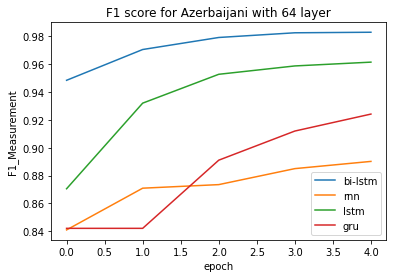

In [62]:
# visualise training history

plt.plot(blstm_64_training_f1)
plt.plot(rnn_64_training_f1)
plt.plot(lstm_64_training_f1)
plt.plot(gru_64_training_f1)
plt.title('F1 score for Azerbaijani with 64 layer')
plt.ylabel('F1_Measurement')
plt.xlabel('epoch')
plt.legend(['bi-lstm', 'rnn', 'lstm', 'gru'], loc="lower right")
plt.show()